# Welcome to *Typhoon Town*

Here you will find some demos that show that the stuff in the *python* folder works. If you want to know more, read the readmes in the folder.

### Adjacency Matrix

Let's see what the *build_adjacency.py* script has produced. Here we visualize the *adjacency_tuples.csv* file by displaying a graph where the nodes are centroids of areas and the edges connect nodes couples that appear in the csv file.

In [1]:
# Let's import what we need
import geopandas as gpd
import shapely as shp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Load all the necessary geographical data
centroids_pdf = pd.read_csv("./AreasCentroids.csv") # read CSV as pandas dataframe

# convert dataframe into GeoDataFrame for plotting
centroids = gpd.GeoDataFrame(
    # select all columns apart from the "geometry" column
    centroids_pdf.loc[:, [c for c in centroids_pdf.columns if c != "geometry"]],
    # use column "geometry" for geometries
    geometry=gpd.GeoSeries.from_wkt(centroids_pdf["geometry"]),
    crs="epsg:4326" # set Coordinate Reference System
)

# load map of polygons
map = gpd.read_file('./AreasGeometriesWithNames.csv', crs = 'epsg:4326', GEOM_POSSIBLE_NAMES='geometry', KEEP_GEOM_COLUMNS='NO')
map.crs = 'epsg:4326'
# convert into GeoDataFrame for plotting
municipality_polygons = gpd.GeoDataFrame(map[["MUNICIPALITY_NAME", "geometry"]], crs = map.crs)

In [24]:
# Load adjacency tuples from csv file
adjacency_tuples_pd = pd.read_csv("./adjacency_files/adjacency_tuples.csv")
adjacency_tuples = adjacency_tuples_pd.to_numpy()

N = len(municipality_polygons)
adjacency_tuples = adjacency_tuples[N:] # ignore the (a, a) tuples
# after every tuple (a, b) there is its symmetric (b, a), 
# so skip every other element since we don't need them
adjacency_tuples = adjacency_tuples[::2]

In [25]:
# Create lines that connect adjacent centroids
lines_geometry = []
for i, j in adjacency_tuples: # _ is the enumeration index, i and j form the tuple (i, j)
    point1 = centroids.iloc[i]['geometry']
    point2 = centroids.iloc[j]['geometry']
    # create line element
    lines_geometry.append(shp.LineString((point1, point2)))

# wrap lines in a geodataframe for plotting
lines = gpd.GeoDataFrame(geometry=lines_geometry, crs=map.crs)

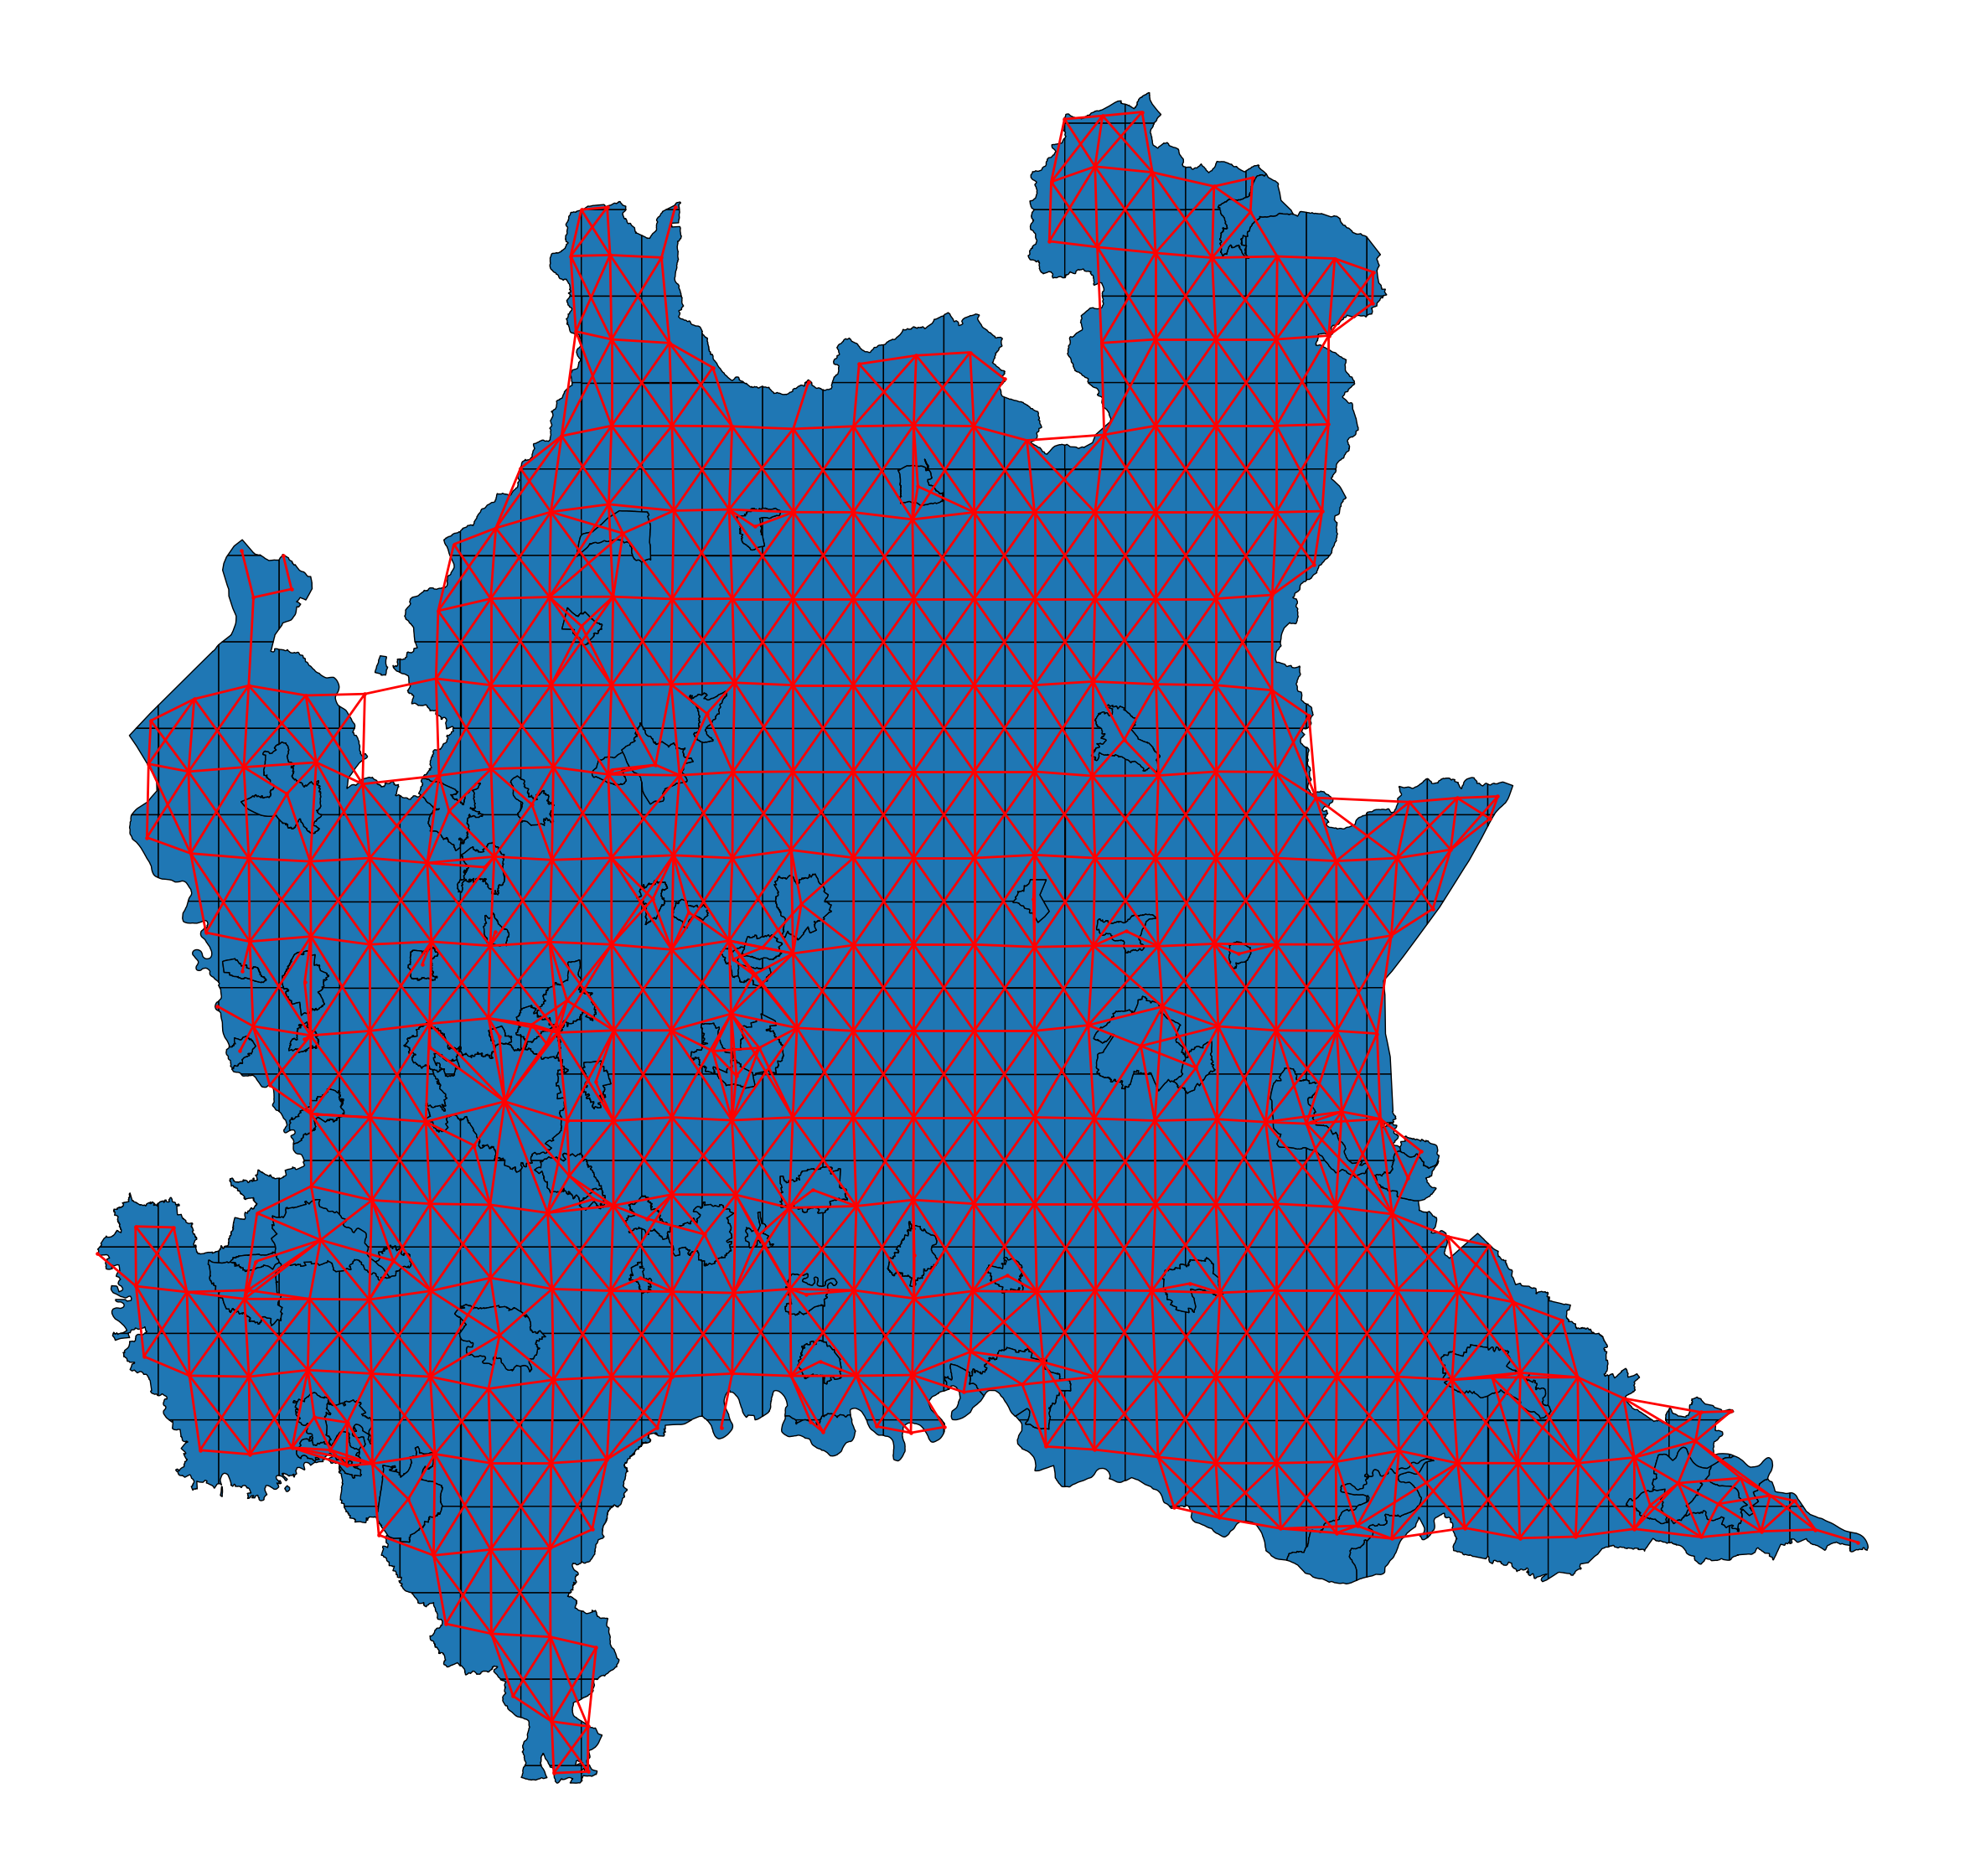

In [26]:
# Plot stuff
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
municipality_polygons.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_axis_off()
centroids.plot(ax=ax, color='red', markersize=5)
lines.plot(ax=ax, color='red', linewidth=2);

We can see that the graph connects only geographically adjacent areas and therefore is cool and good.

### Cost matrices

Let's now visualize the cost matrices. Here, the centroids of the areas are colored depending on their distance from a selected city. Let's use the wonderful city of CREMONA (the older sister of Crema) as an example. The visualization doesn't work very well because pyplot normalizes the data when mapping it to colors and therefore the exponential cost looks higher than the polynomial ones. Too bad!

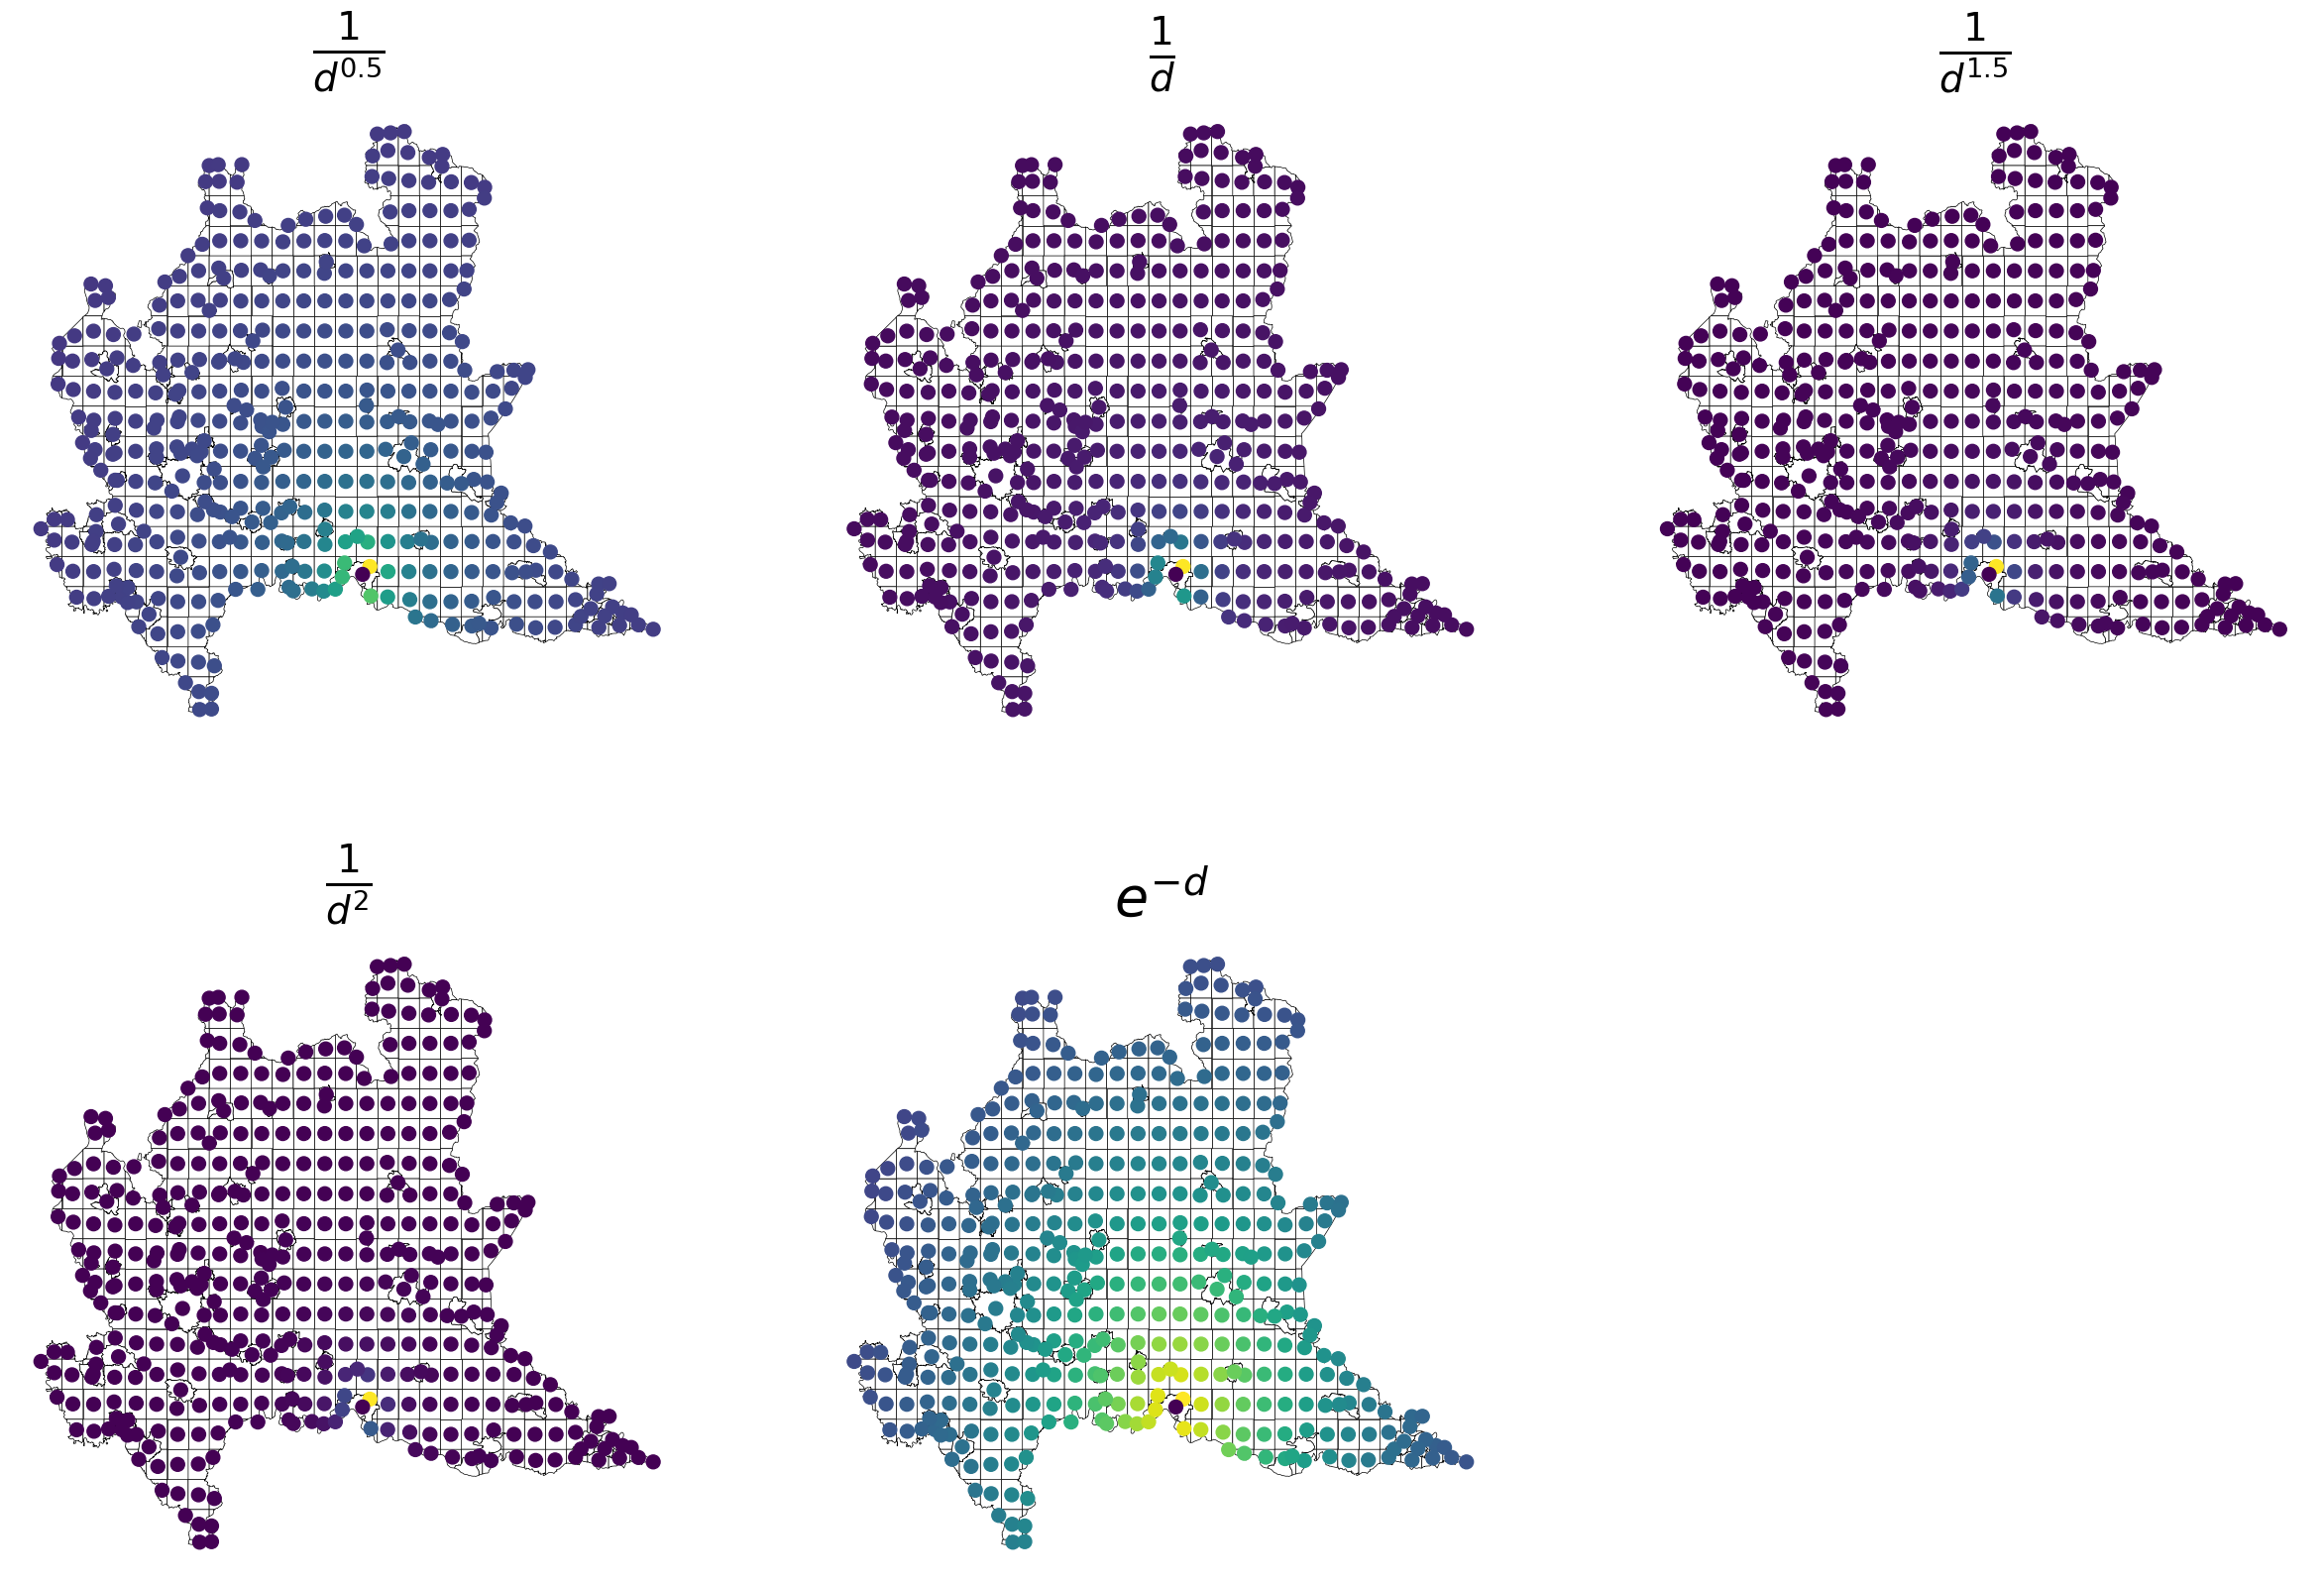

In [38]:
cost_function_labels = [
    "$\\frac{1}{d^{0.5}}$",
    "$\\frac{1}{d}$",
    "$\\frac{1}{d^{1.5}}$",
    "$\\frac{1}{d^{2}}$",
    "$e^{-d}$",
]

ID = 418 # Cremona's ID

fig, ax = plt.subplots(2, 3, figsize=(30, 20))
fig.delaxes(ax[1][2]) # remove the 6th plot since it's not used

for i in range(5):
    row = i//3
    col = i%3
    plot_ax = ax[row][col]
    plot_ax.set_axis_off()
    plot_ax.set_title(cost_function_labels[i], fontsize=40)

    cost_matrix = pd.read_csv(f"../python/cost_matrices/cost_matrix_{i}.csv")
    m = cost_matrix.to_numpy()

    distances_from_munic = m[ID]
    colors = distances_from_munic
    
    municipality_polygons.plot(ax=plot_ax, edgecolor='black', color="white", linewidth=0.5)
    centroids.plot(ax=plot_ax, c=colors, markersize=100)

### Wind stuff

Here comes the wind stuff. Let's first visualize the winds at 100m using fancy plots with fancy names.

In [29]:
#Let's load the digested wind data first
wind_data = pd.read_csv("./wind_stuff/Aggregated_wind_data.csv")

# extract data to easily feed it to the pyplot method
arrows={'X':[], 'Y':[], 'U':[], 'V':[]}
for i, data in wind_data.iterrows():
    arrows['X'].append(data['Longitude'])
    arrows['Y'].append(data['Latitude'])
    
    #from polar to cartesian
    arg = data['prevalent_direction_100m']
    radius = data['average_speed_100m']

    arrows['U'].append(np.cos(arg)*radius)
    arrows['V'].append(np.sin(arg)*radius)

# let's calculate the magnitudes for better visualization
u = np.array(arrows['U'])
v = np.array(arrows['V'])

M = np.sqrt(u*u+v*v)

In [30]:
# To visualize the streamplot, we need to interpolate wind data to have a better plot.

# build function for interpolating wind vectors    
grid_points = list(zip(arrows['X'], arrows['Y']))

from scipy import interpolate
interpX = interpolate.LinearNDInterpolator(grid_points, arrows['U'])
interpY = interpolate.LinearNDInterpolator(grid_points, arrows['V'])

X = np.linspace(min(arrows['X']), max(arrows['X']), 200)
Y = np.linspace(min(arrows['Y']), max(arrows['Y']), 200)

x, y = np.meshgrid(X, Y)  # 2D grid for interpolation
u, v = interpX(x, y), interpY(x, y) # interpolated wind data

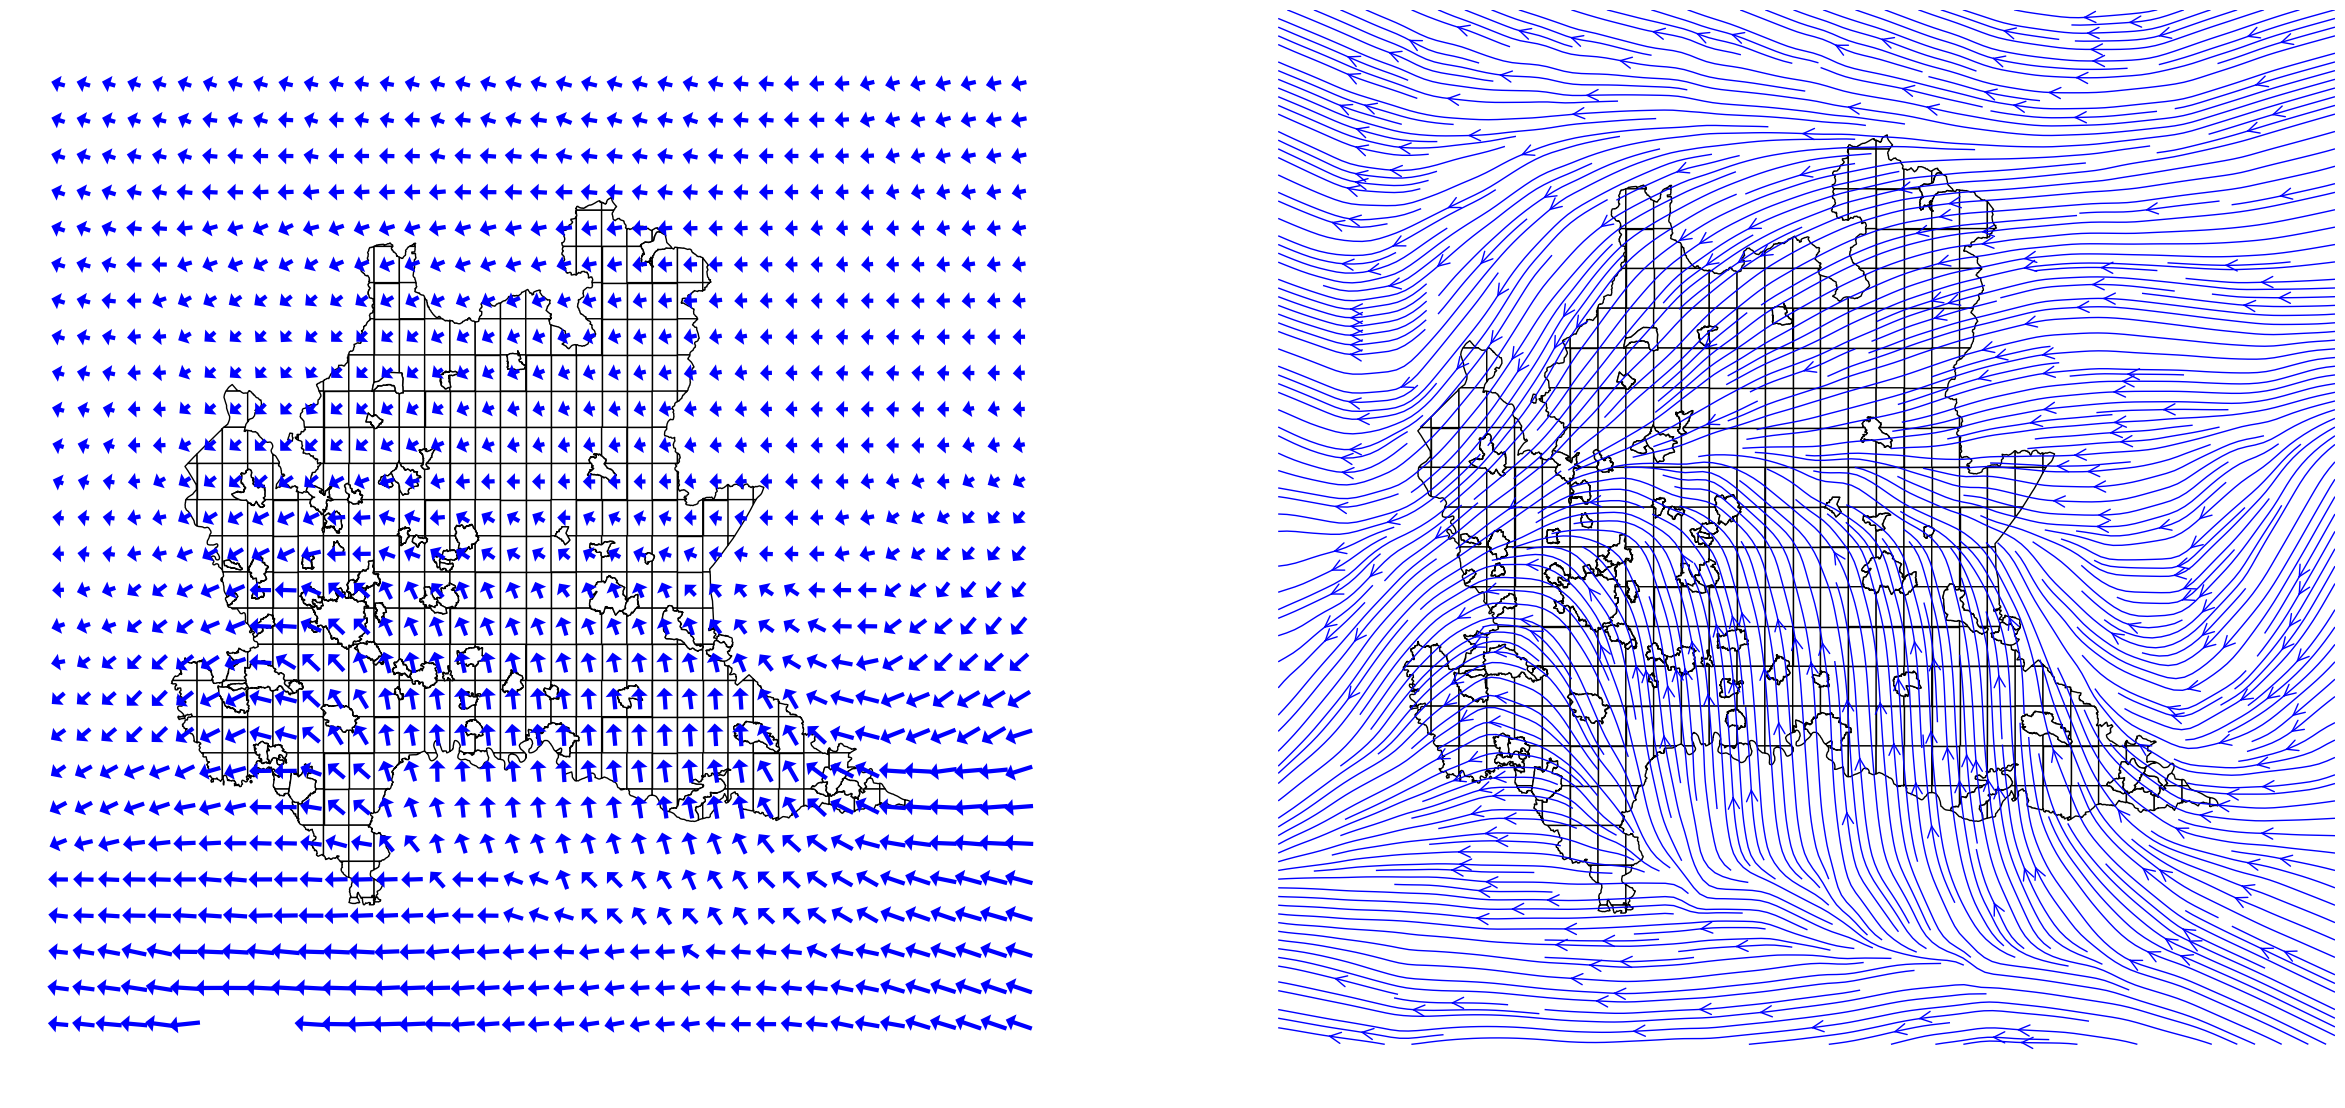

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].set_axis_off()
ax[1].set_axis_off()

municipality_polygons.plot(ax=ax[0], edgecolor='black', color='white', linewidth=1)
municipality_polygons.plot(ax=ax[1], edgecolor='black', color='white', linewidth=1)

# first the quiver plot for the arrows
ax[0].quiver(arrows['X'],arrows['Y'],arrows['U'],arrows['V'], 
          #M,
          #cmap='jet',
          color='blue',
          pivot='mid',
          headlength=2,
          headwidth=4,
          headaxislength=2,
          width = 0.004
)

# then the majestic streamplot
ax[1].streamplot(x, y, u, v, density=4, linewidth=1, color='blue', arrowstyle='->', arrowsize=2)

### Wind Adjacency

Let's now see how the wind adjacency matrix actually represents areas as adjacent if they are on the same wind current (up to an angle parameter and without considering distance).

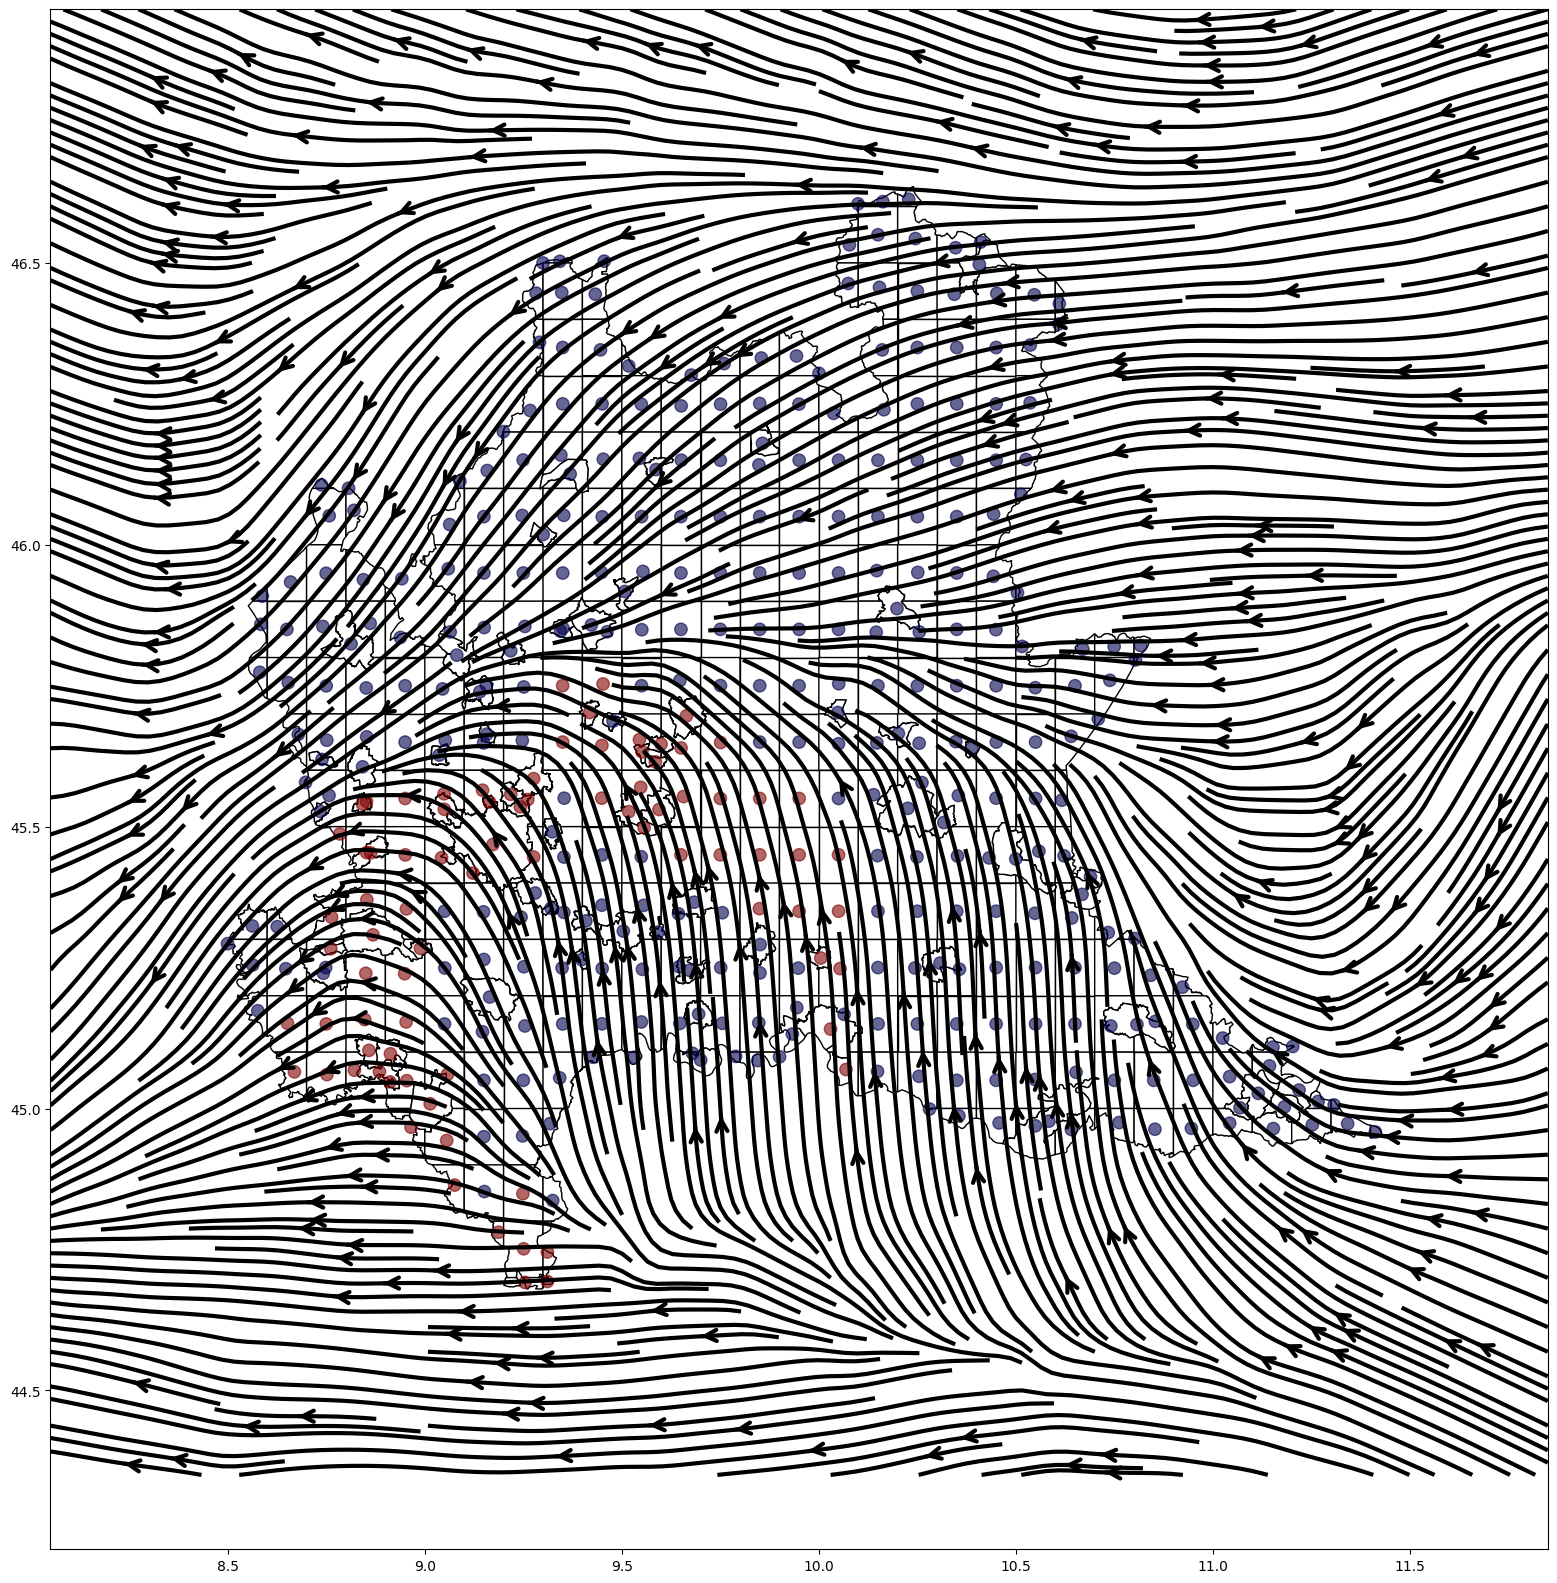

In [37]:
ID = 418 # Cremona

# Let's use the 30deg, 100 meters wind adjacencies
adjacency_matrix = pd.read_csv(
    "./adjacency_files/wind_adjacency_matrix_100m_30.csv"
    ).to_numpy()

color_list = []
for adj in adjacency_matrix[ID]:
    color_list.append(adj == 1)

centroids['color']=color_list

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
municipality_polygons.plot(ax=ax, edgecolor='black', color='white', linewidth=1)
centroids.plot(ax=ax, markersize=80, column="color", alpha=0.6 , cmap='seismic')
ax.streamplot(x, y, u, v, 
              density=4, 
              linewidth=3, 
              color='black',
              arrowstyle='->', 
              arrowsize=2)

pretty neat right?